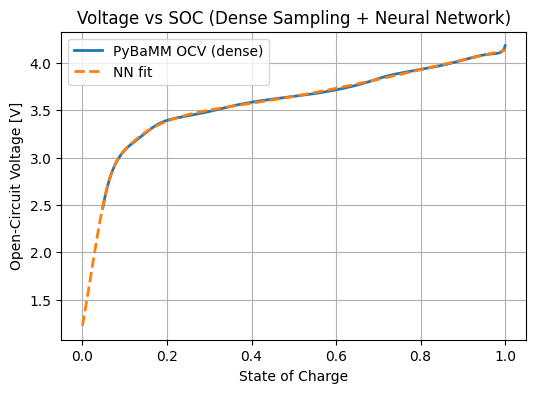

In [33]:
import numpy as np
import pybamm
import tensorflow as tf
import matplotlib.pyplot as plt

model_pb = pybamm.lithium_ion.SPM()
param = pybamm.ParameterValues("Chen2020")
experiment = pybamm.Experiment(["Discharge at 1C for 1 hour"])
sim = pybamm.Simulation(model_pb, parameter_values=param, experiment=experiment)
solution = sim.solve()

t_dense = np.linspace(0, solution.t[-1], 600)

c_avg = solution["Average negative particle concentration [mol.m-3]"](t=t_dense)
soc = c_avg / c_avg[0]
soc = np.clip(soc, 0.0, 1.0)

U_p = solution["X-averaged positive electrode open-circuit potential [V]"](t=t_dense)
U_n = solution["X-averaged negative electrode open-circuit potential [V]"](t=t_dense)
voltage = U_p - U_n

idx = np.argsort(soc)
soc = soc[idx]
voltage = voltage[idx]

X = soc.reshape(-1, 1).astype(np.float32)
y = voltage.reshape(-1, 1).astype(np.float32)

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="tanh", input_shape=(1,)),
    tf.keras.layers.Dense(64, activation="tanh"),
    tf.keras.layers.Dense(1)
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse"
)

model.fit(X, y, epochs=2000, batch_size=64, verbose=0)

soc_fit = np.linspace(0, 1, 800).reshape(-1, 1).astype(np.float32)
v_pred = model(soc_fit).numpy().flatten()

plt.figure(figsize=(6,4))
plt.plot(soc, voltage, "-", linewidth=2, label="PyBaMM OCV (dense)")
plt.plot(soc_fit.flatten(), v_pred, "--", linewidth=2, label="NN fit")
plt.xlabel("State of Charge")
plt.ylabel("Open-Circuit Voltage [V]")
plt.title("Voltage vs SOC (Dense Sampling + Neural Network)")
plt.legend()
plt.grid(True)
plt.show()

def voltage_from_soc(soc_in):
    soc_in = np.asarray(soc_in).reshape(-1, 1).astype(np.float32)
    return model(soc_in).numpy().flatten()